In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
import numpy as np
from tools import *
from fitters import *
from plots import *
set_seaborn({'figure.figsize': (8,6)})


In [119]:
noise = 1e-4
beta = 0
e_s = np.array([-0.8, -0.15, 1.5])
a_s = np.array([1.0, 0.2, 0.01])
dim = 10
dt = 0.1
time = np.arange(0, 3+dt, dt)
pred_time = time[dim:]
filter_time = np.arange(-dim, 0)
N = len(time)
true_eigs = np.sort(np.exp(e_s*dt))[::-1]

# build X_series
components = []
for i in range(len(e_s)):
    c = exp_f(time, e_s[i], a_s[i])
    components.append(c)
X_series = np.sum(components, axis=0)

# build Y_series
Y_series = components[np.argmax(e_s)]
Y_series = Y_series[dim:]


In [120]:
iterations = 10000

X, P, T = [], [], [] 
for i in range(iterations):
    noise_series = noise * np.random.randn(N)
    X_series_noise = X_series + noise_series
    # ALGO
    Xhan = build_hankel(X_series_noise, dim)
    X0 = Xhan[:, :-1]
    Xp = Xhan[:, 1:]
    lam = beta * np.eye(dim)
    X0Xp = X0 @ Xp.T
    X0X0 = X0 @ X0.T
    # solve eigenvalue problem
    w, vl = scipy.linalg.eig(
        X0Xp, (X0X0+lam), overwrite_a=True, overwrite_b=True)

    theta = vl[:, np.nanargmax(np.abs(w))]
    w = np.sort(np.real_if_close(w))[::-1]

    theta /= theta[-1]
    P_series = theta.real @ Xhan
    P_series /= P_series[0]/Y_series[0]

    X.append(X_series_noise)
    T.append(theta.real)
    P.append(P_series)


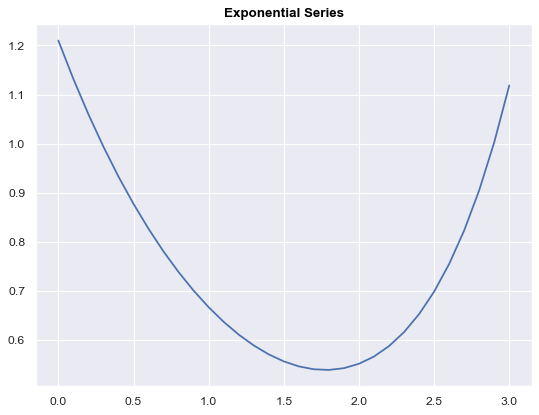

In [121]:
X_mean, X_std = np.mean(X, axis=0), np.std(X, axis=0)
plt.plot(time, X_mean)
plt.fill_between(time, X_mean-X_std, X_mean+X_std, alpha=0.2)
plt.title('Exponential Series')
plt.show()

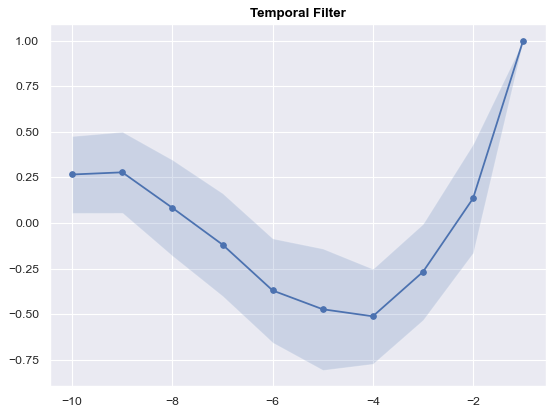

In [127]:
T_mean, T_std = np.mean(T, axis=0), np.std(T, axis=0)
plt.plot(filter_time, T_mean, '.-')
plt.fill_between(filter_time, T_mean-T_std, T_mean+T_std, alpha=0.2)
plt.title('Temporal Filter')
plt.show()

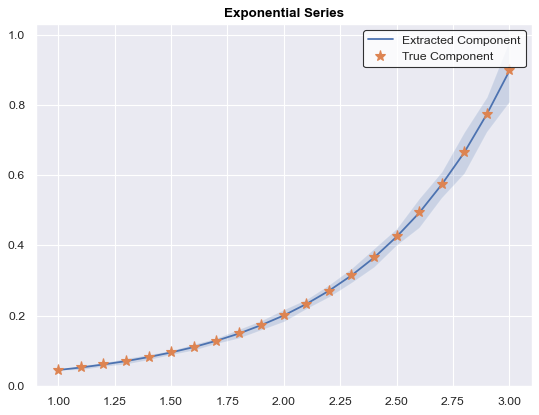

In [126]:
P_mean, P_std = np.mean(P, axis=0), np.std(P, axis=0)
plt.plot(pred_time, P_mean, label='Extracted Component')
plt.fill_between(pred_time, P_mean-P_std, P_mean+P_std, alpha=0.2)
plt.plot(pred_time, Y_series, '*', label='True Component')
plt.legend()
plt.title('Exponential Series')
plt.show()
